# Automated Mitosis Detection and Analysis in Histological Images Using OpenCV and Image Processing Techniques

## Efim Shliamin

---

In [3]:
# Plots are displayed inline in the notebook
%matplotlib inline

'Enter' - display only the results, 
'p' - display the results along with an automatic check:
 p


Found mitoses in the image '14_2.png': 2 ✅
Found mitoses in the image '16_1.png': 1 ✅
Found mitoses in the image '10_1.png': 1 ✅
Found mitoses in the image '12_3.png': 3 ✅
Found mitoses in the image '09_2.png': 2 ✅
Found mitoses in the image '15_0.png': 0 ✅
Found mitoses in the image '17_0.png': 0 ✅
Found mitoses in the image '13_1.png': 1 ✅
Found mitoses in the image '08_1.png': 1 ✅
Found mitoses in the image '11_0.png': 0 ✅
Found mitoses in the image '06_3.png': 3 ✅
Found mitoses in the image '04_3.png': 3 ✅
Found mitoses in the image '19_2.png': 2 ✅
Found mitoses in the image '02_2.png': 2 ✅
Found mitoses in the image '20_5.png': 5 ✅
Found mitoses in the image '05_0.png': 0 ✅
Found mitoses in the image '07_2.png': 2 ✅
Found mitoses in the image '01_0.png': 0 ✅
Found mitoses in the image '18_3.png': 3 ✅
Found mitoses in the image '03_1.png': 1 ✅

Percentage of correct solutions:  100.0 %


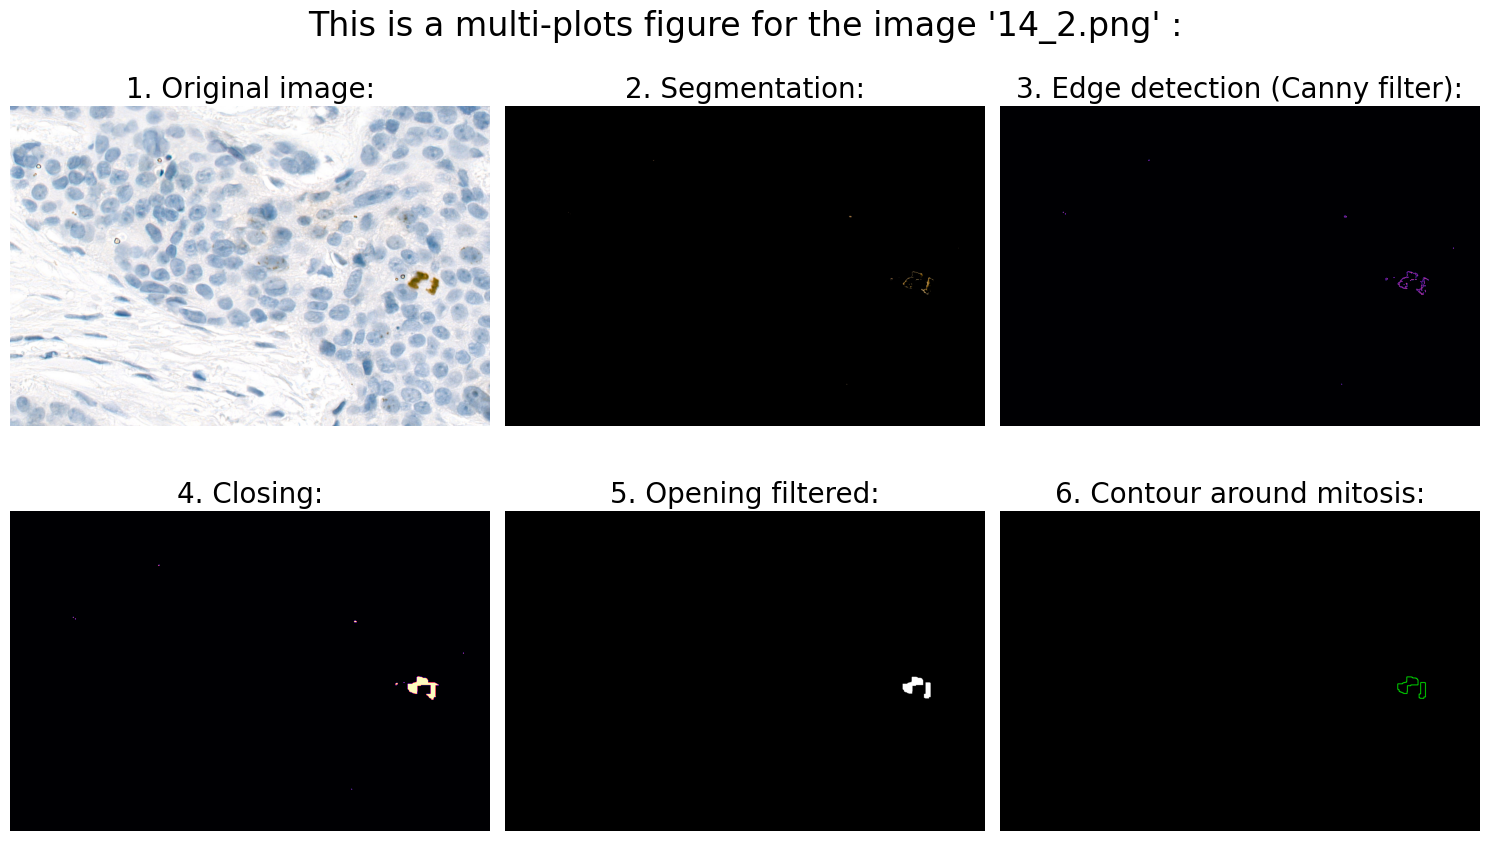

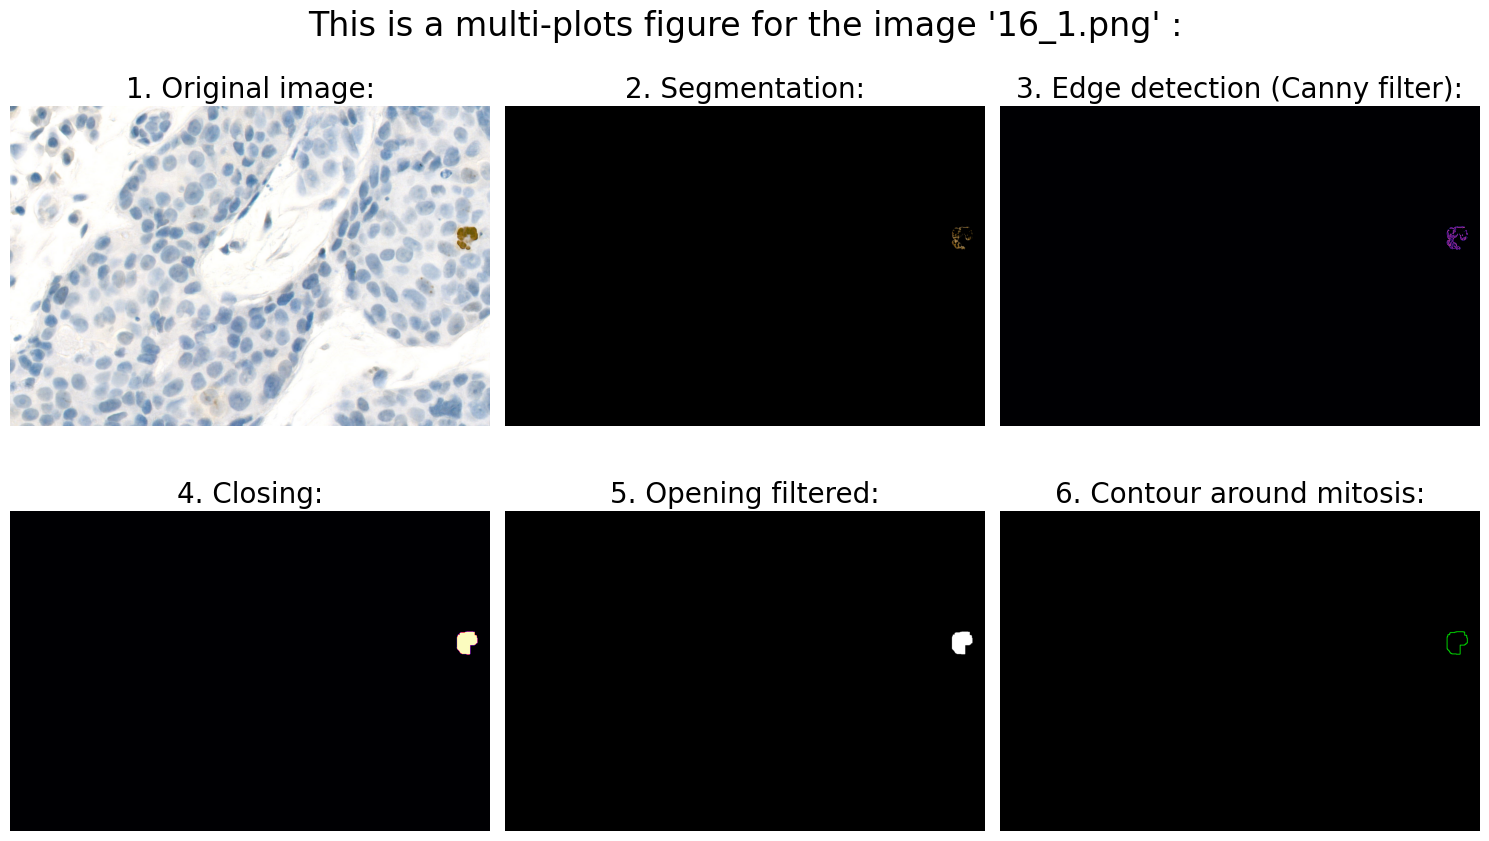

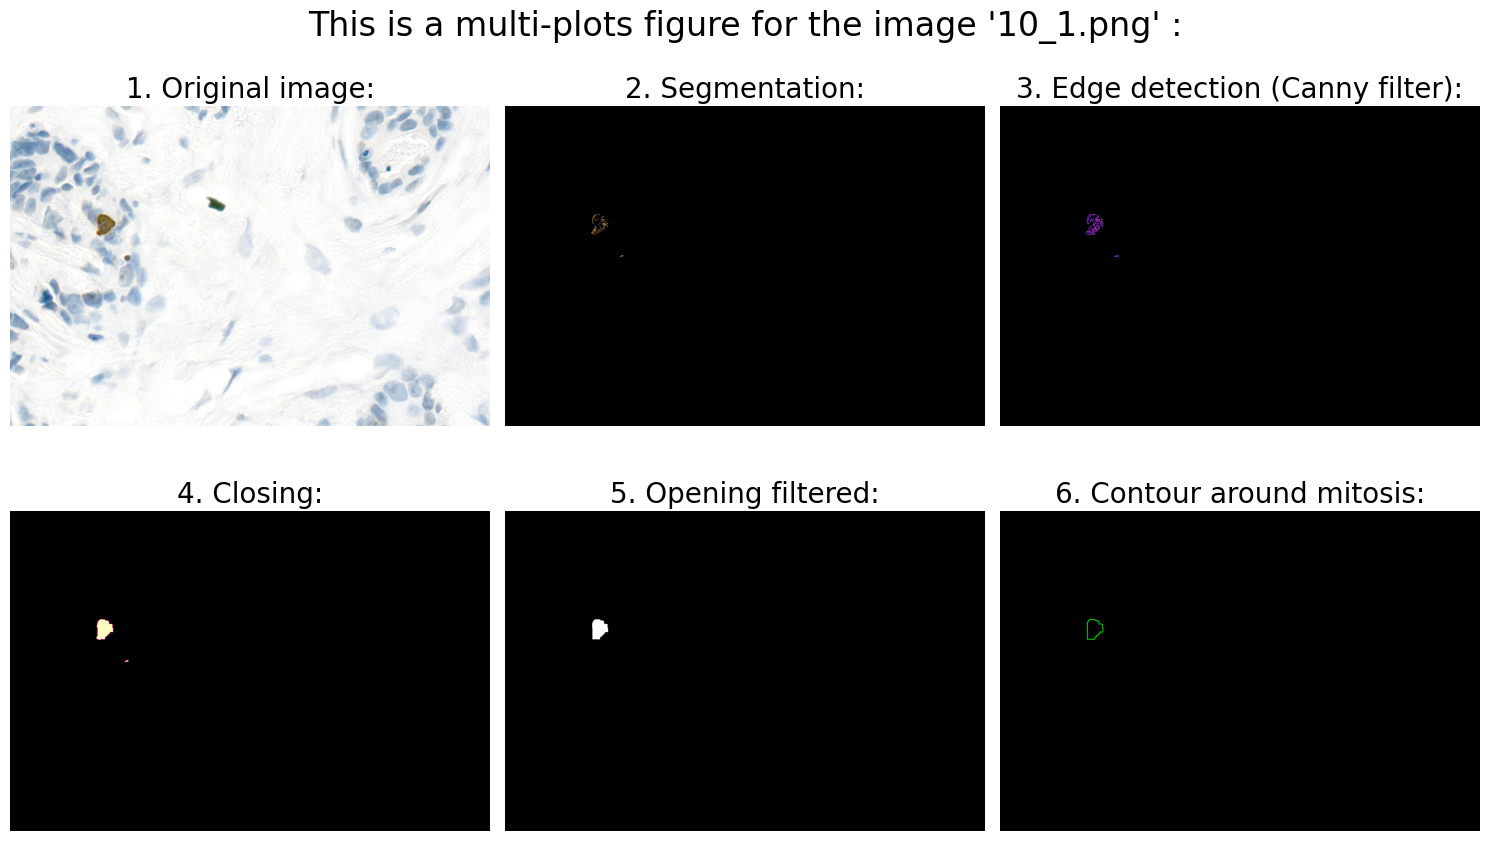

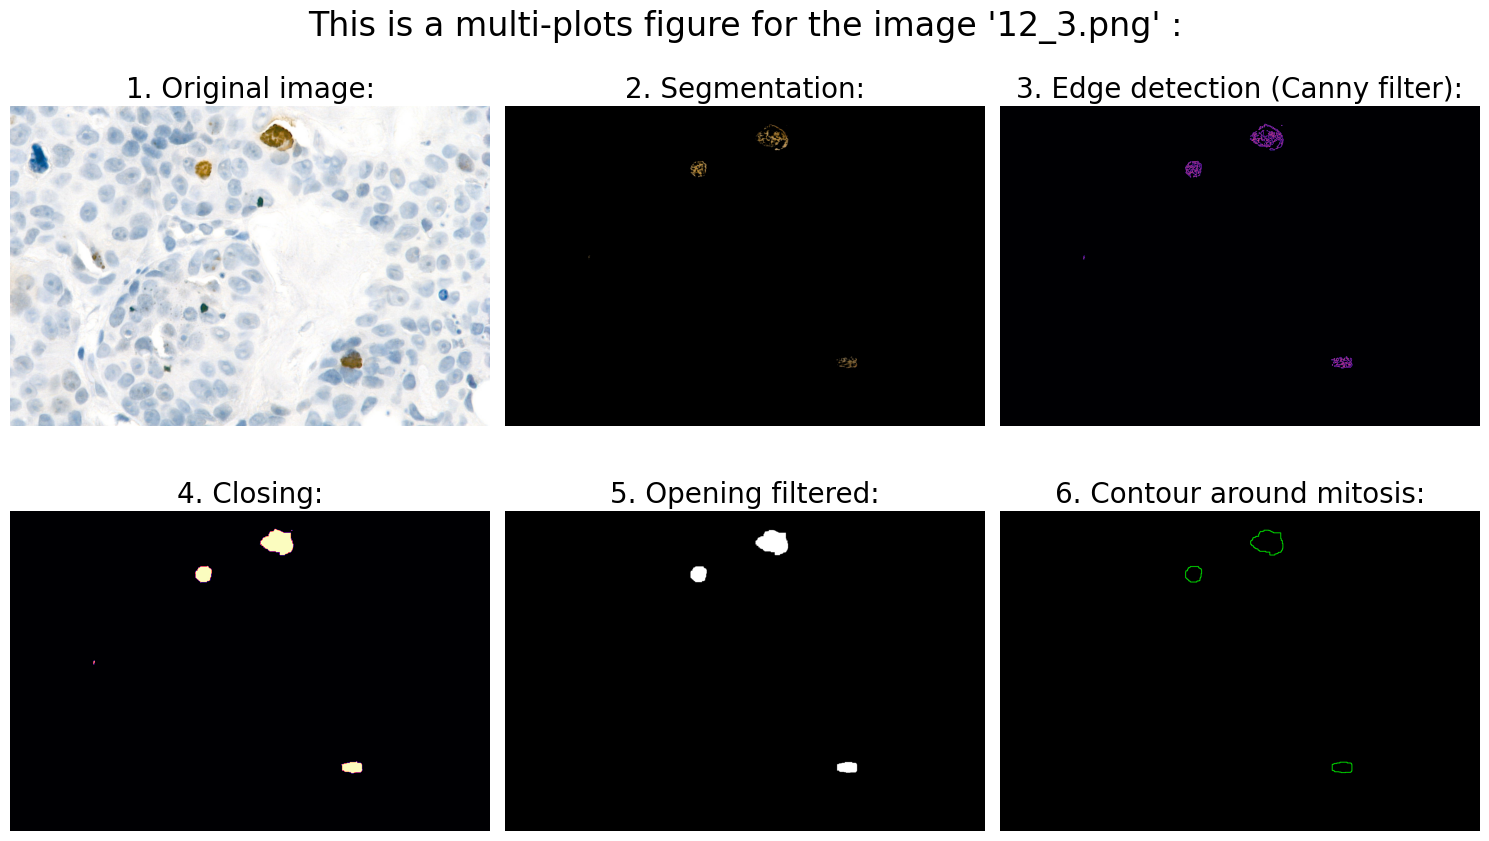

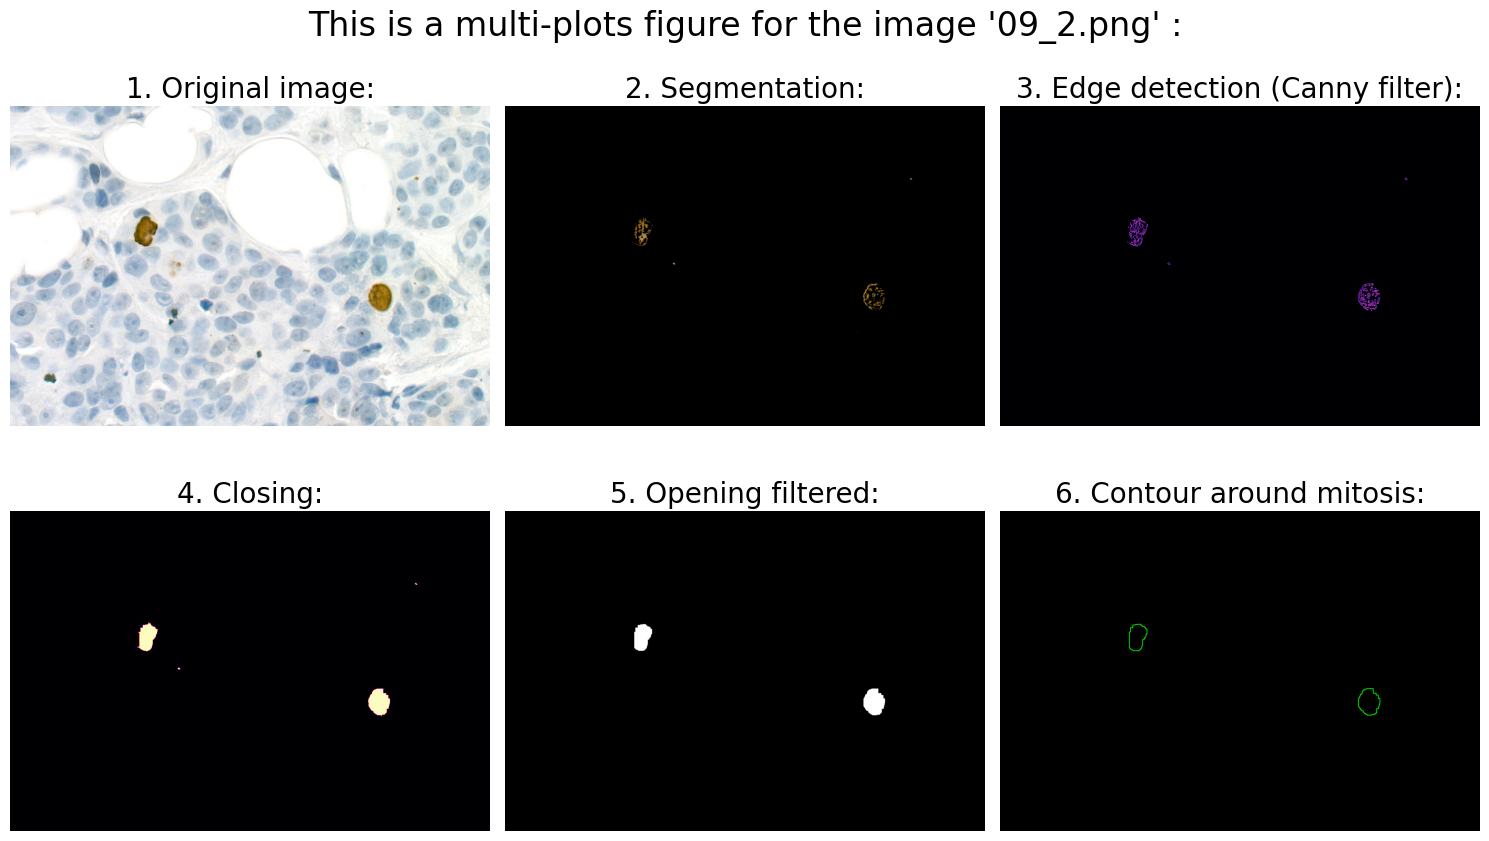

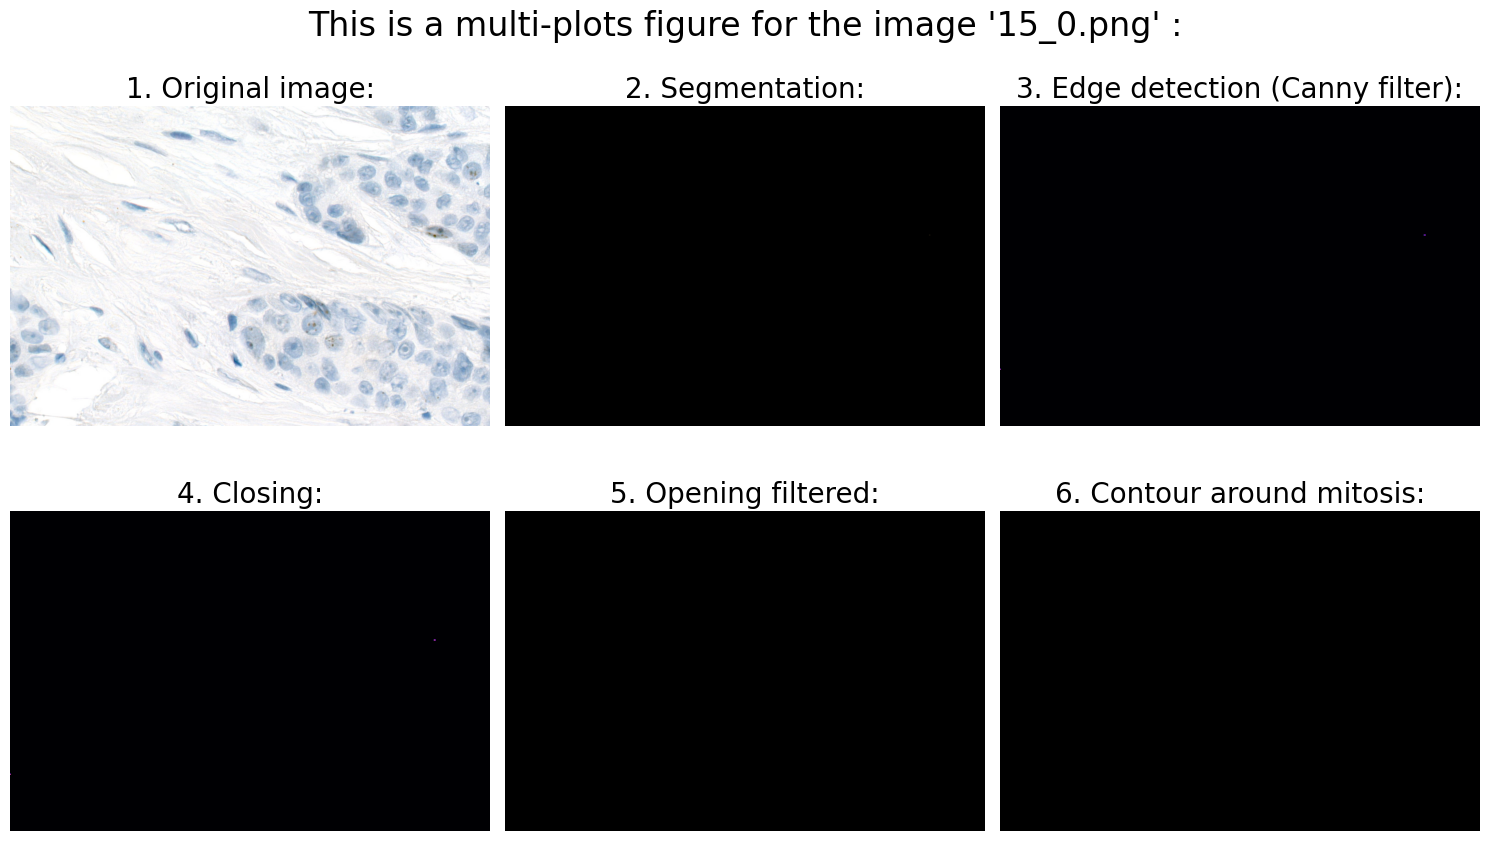

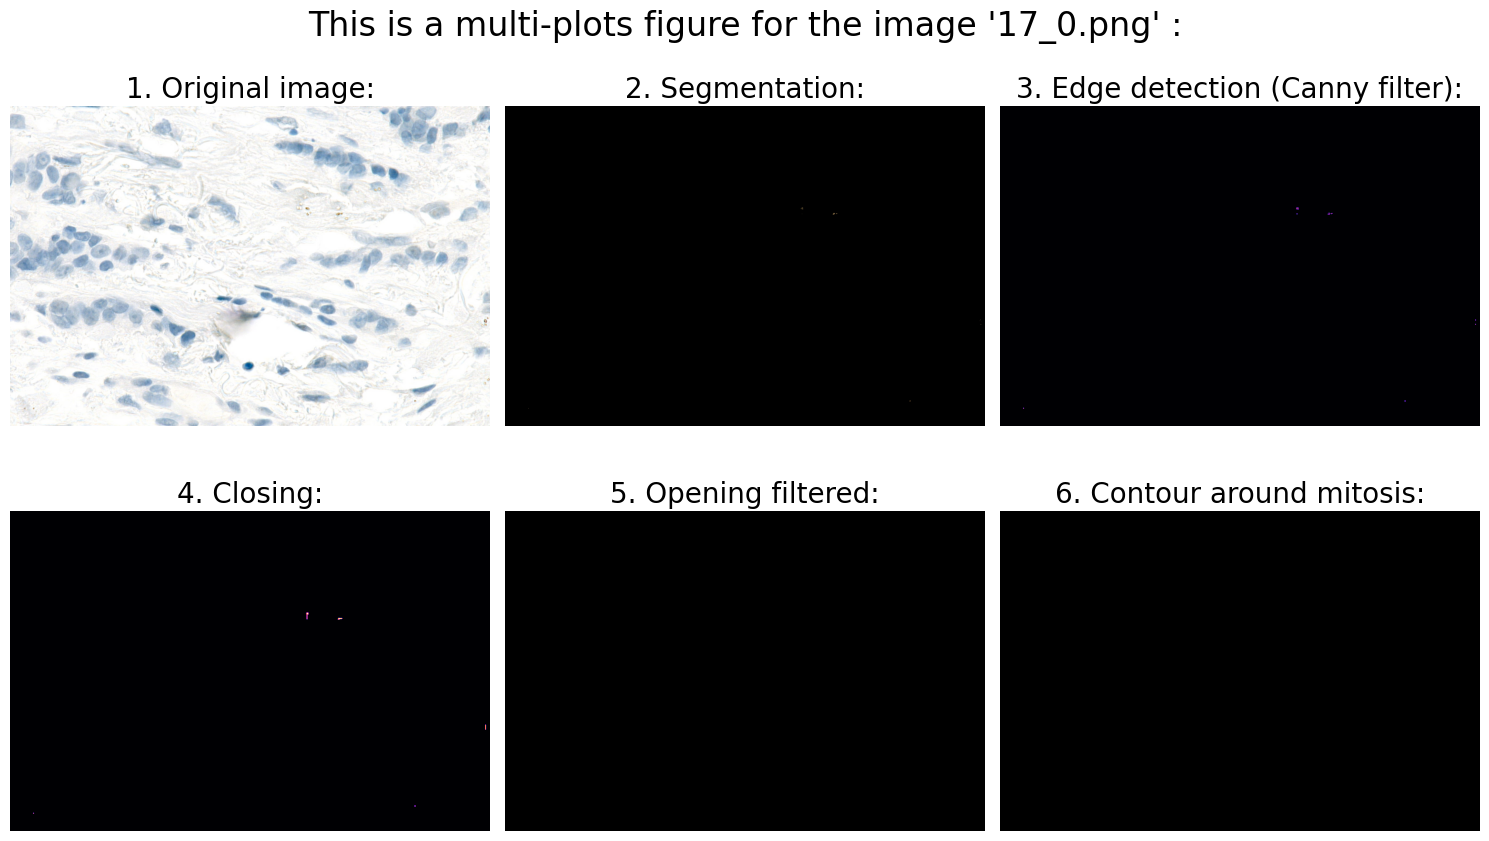

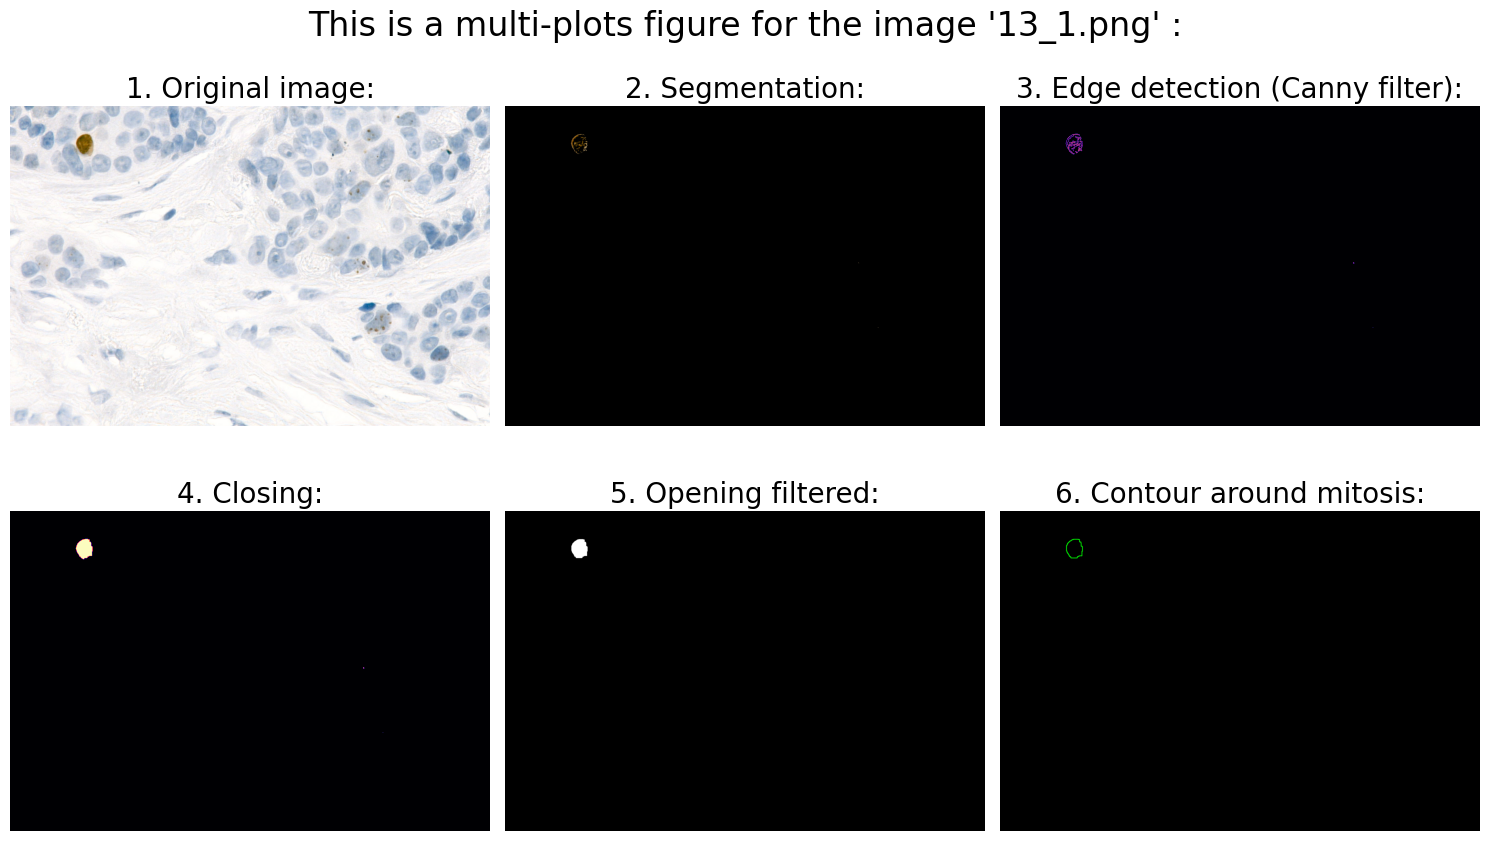

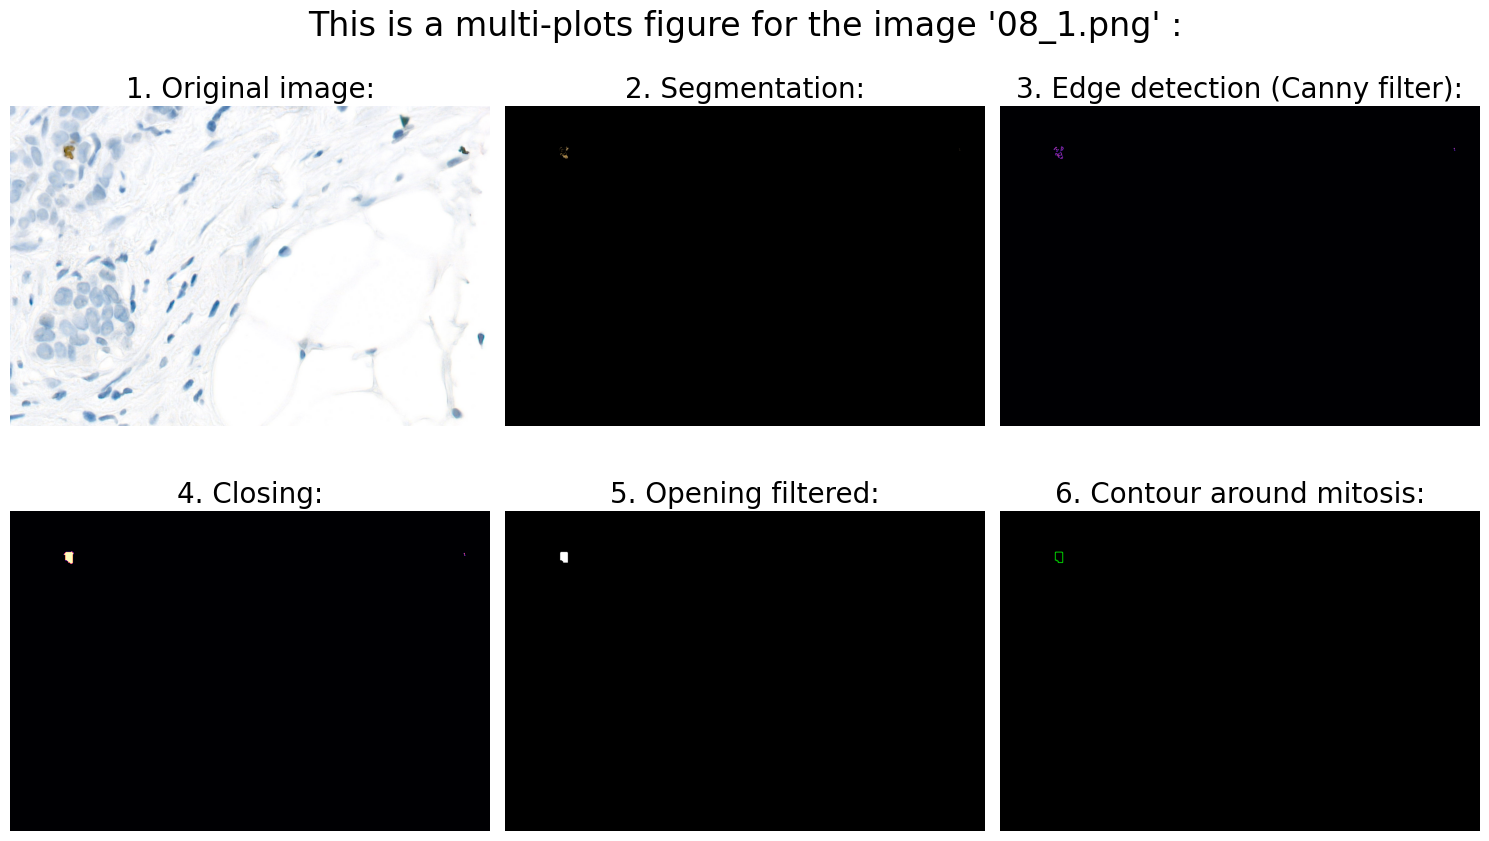

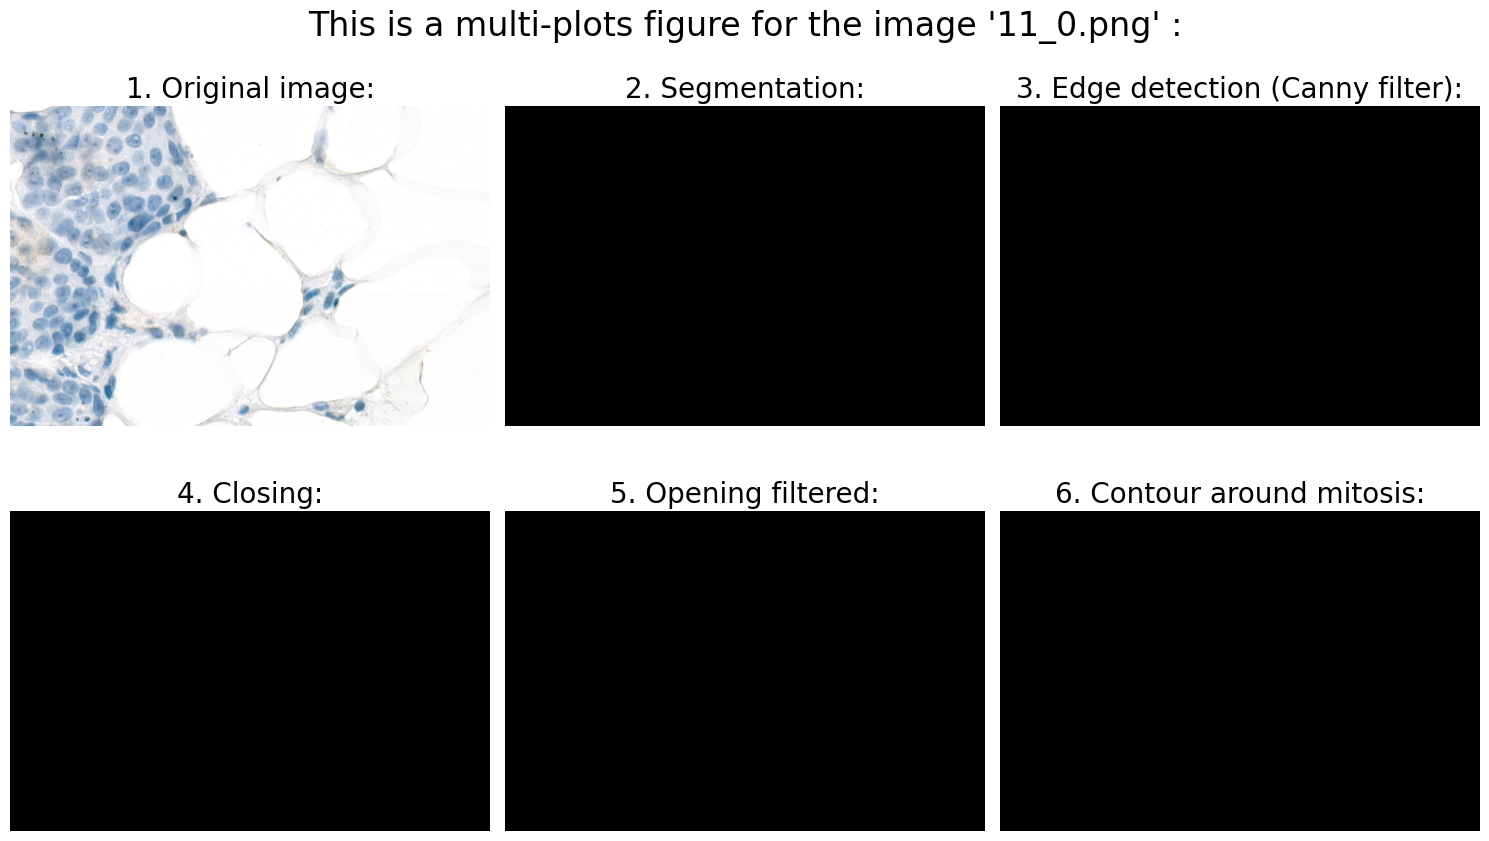

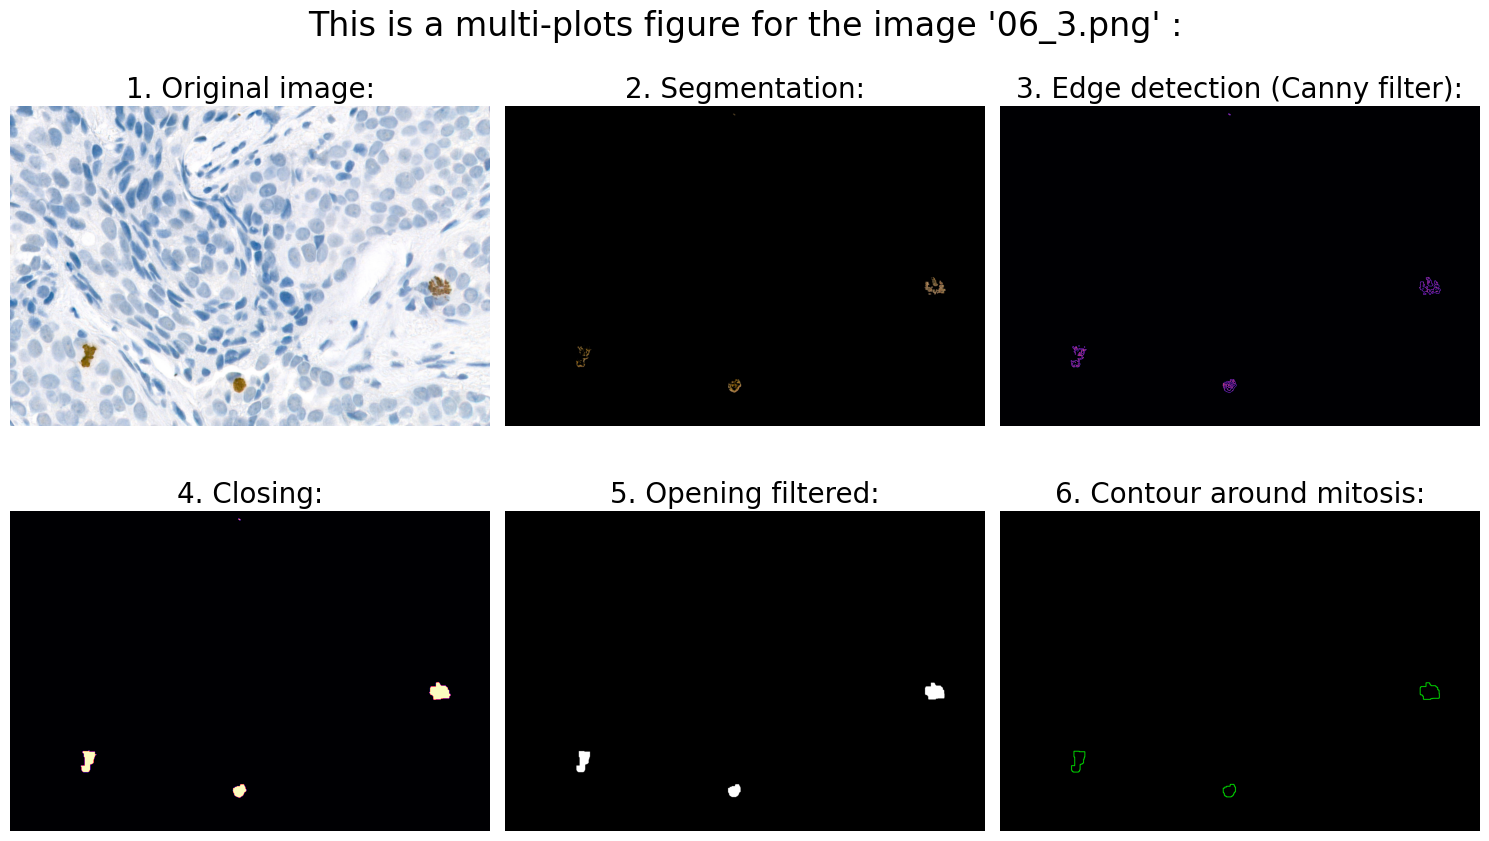

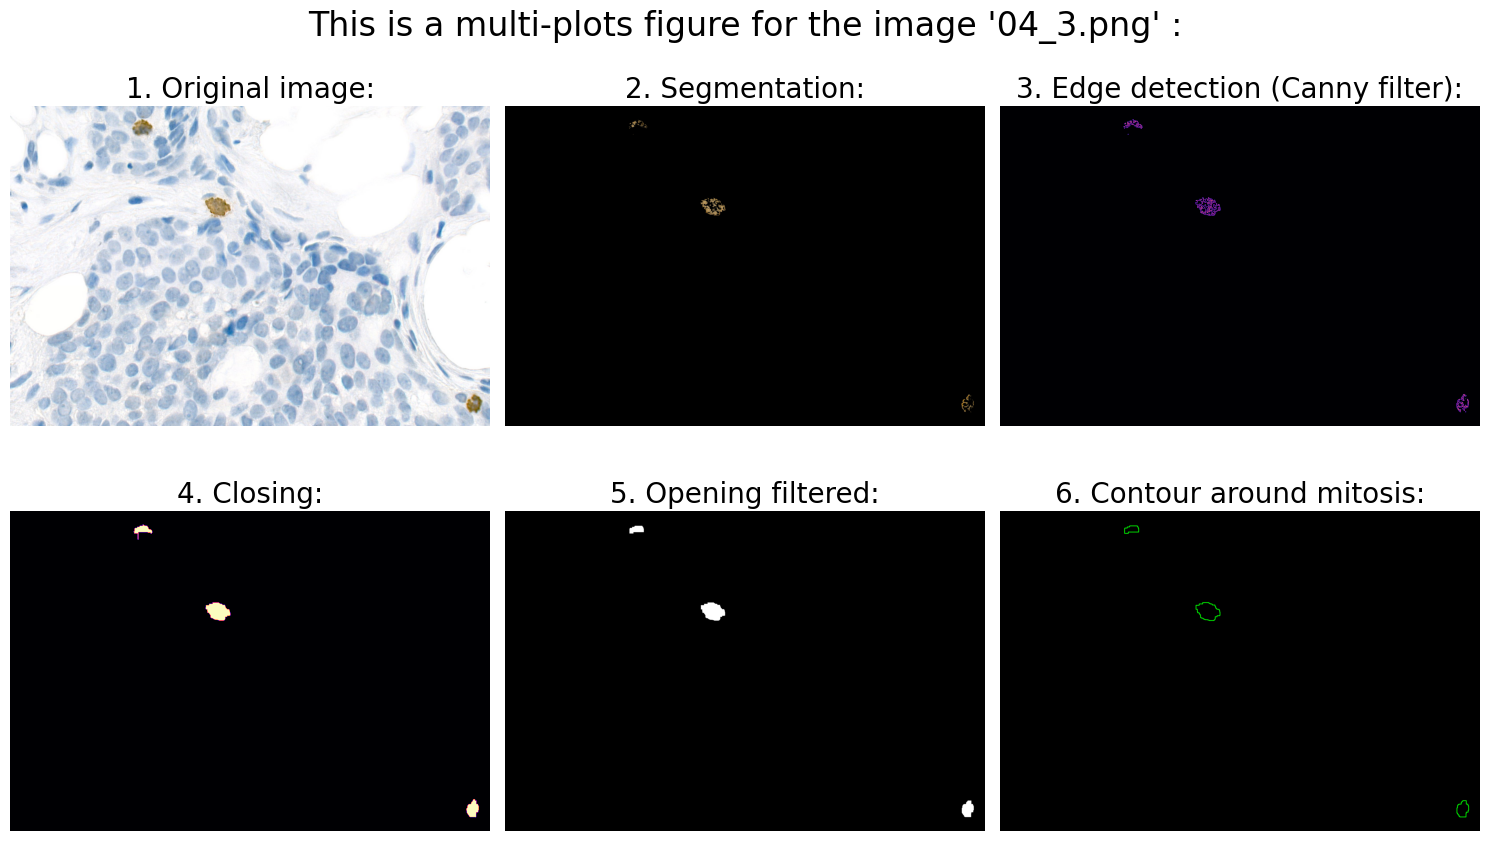

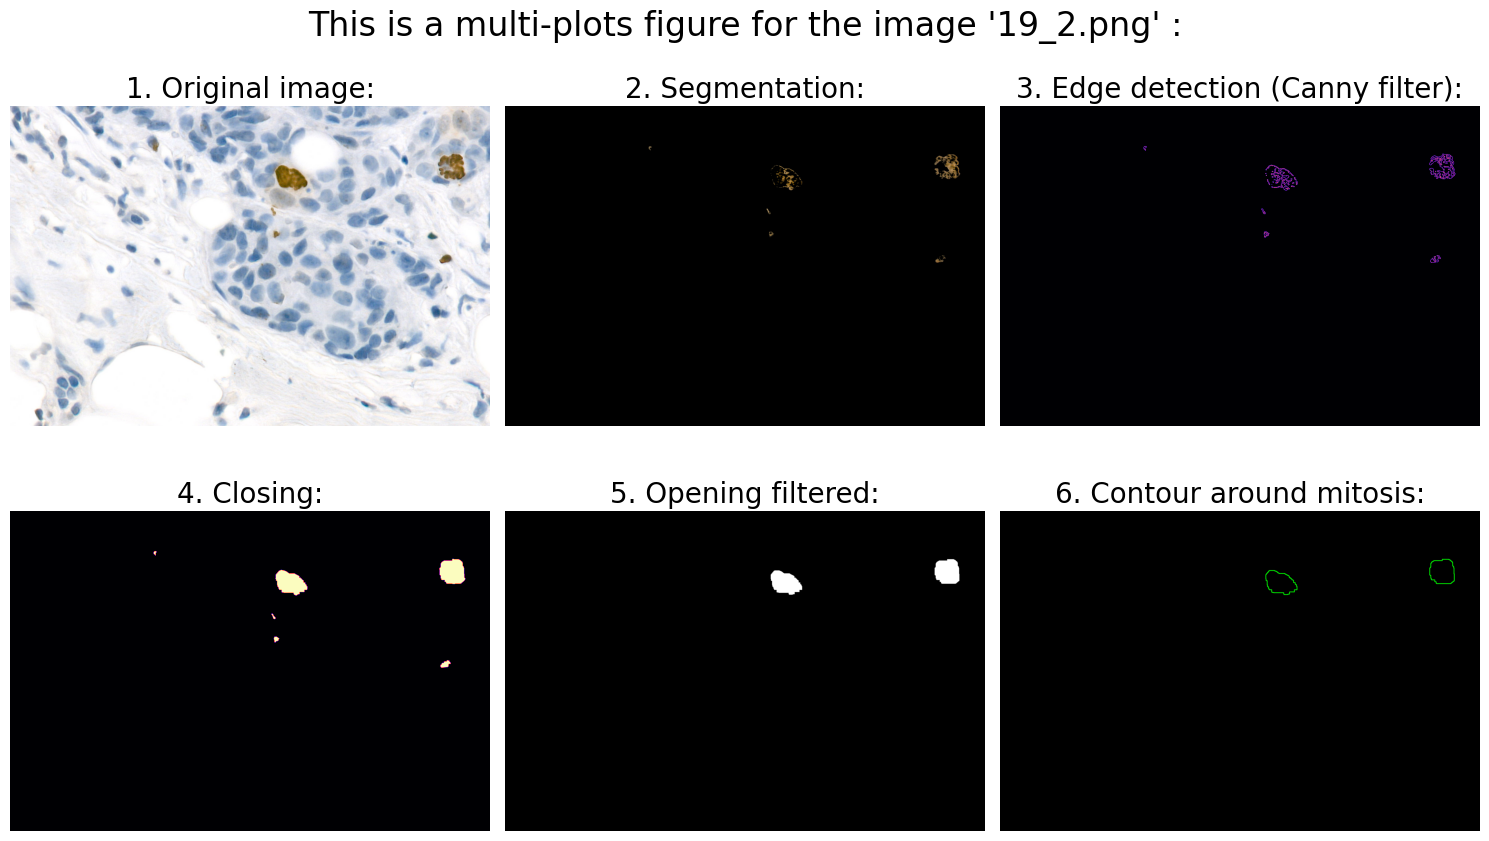

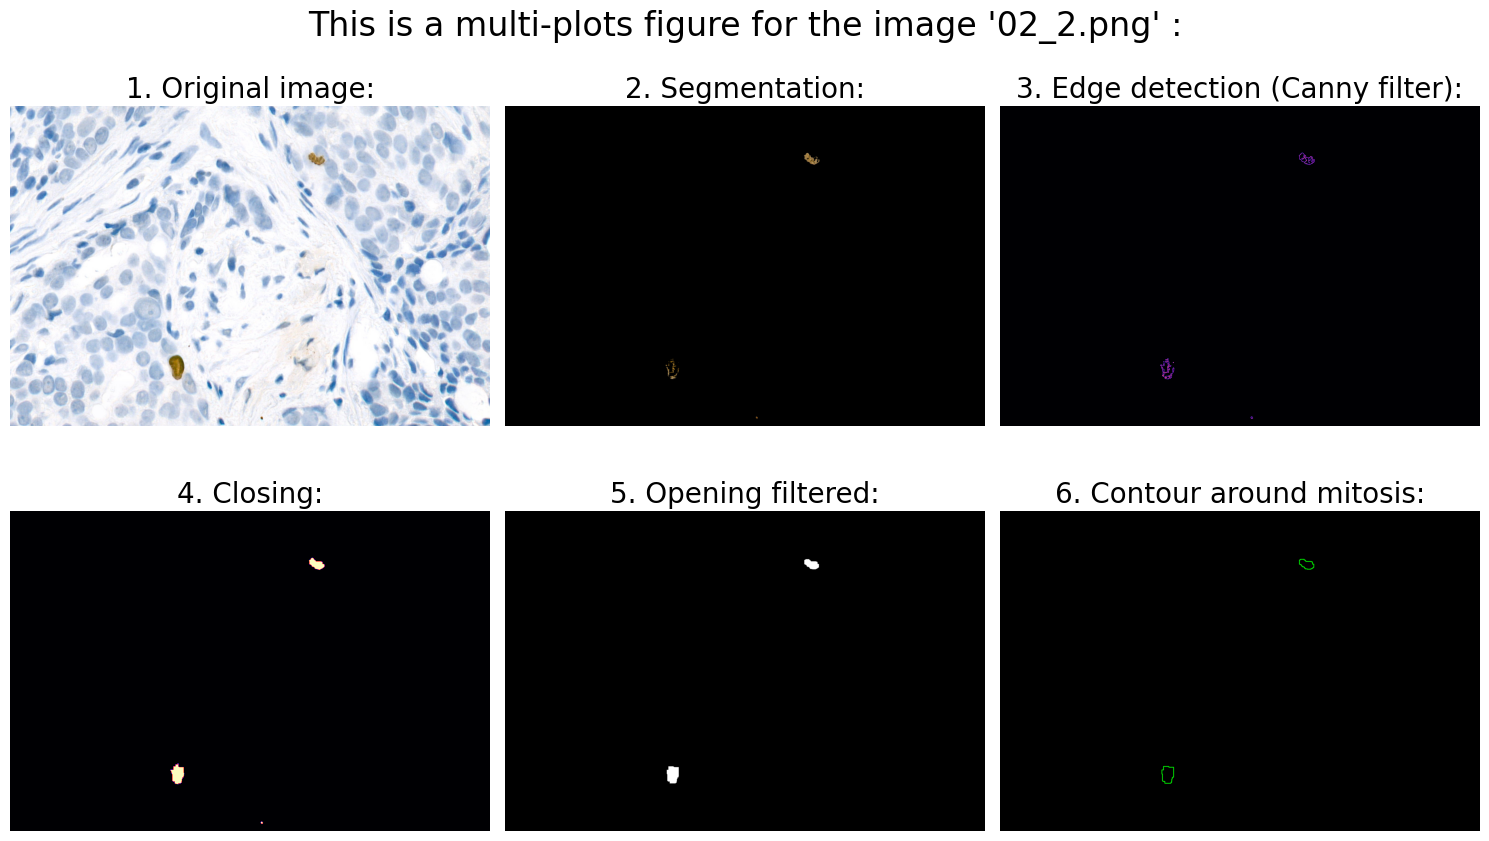

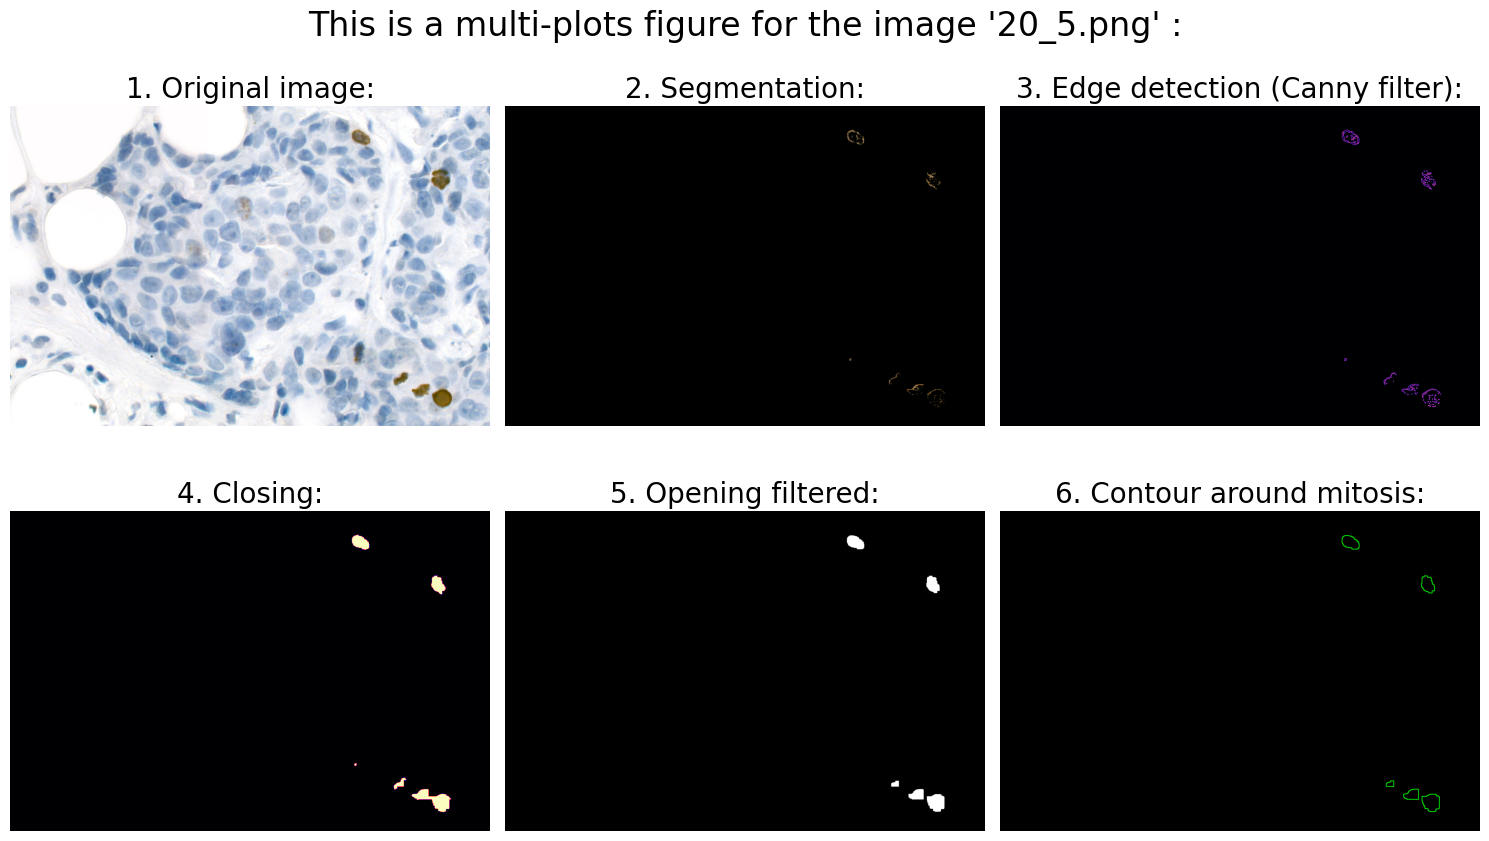

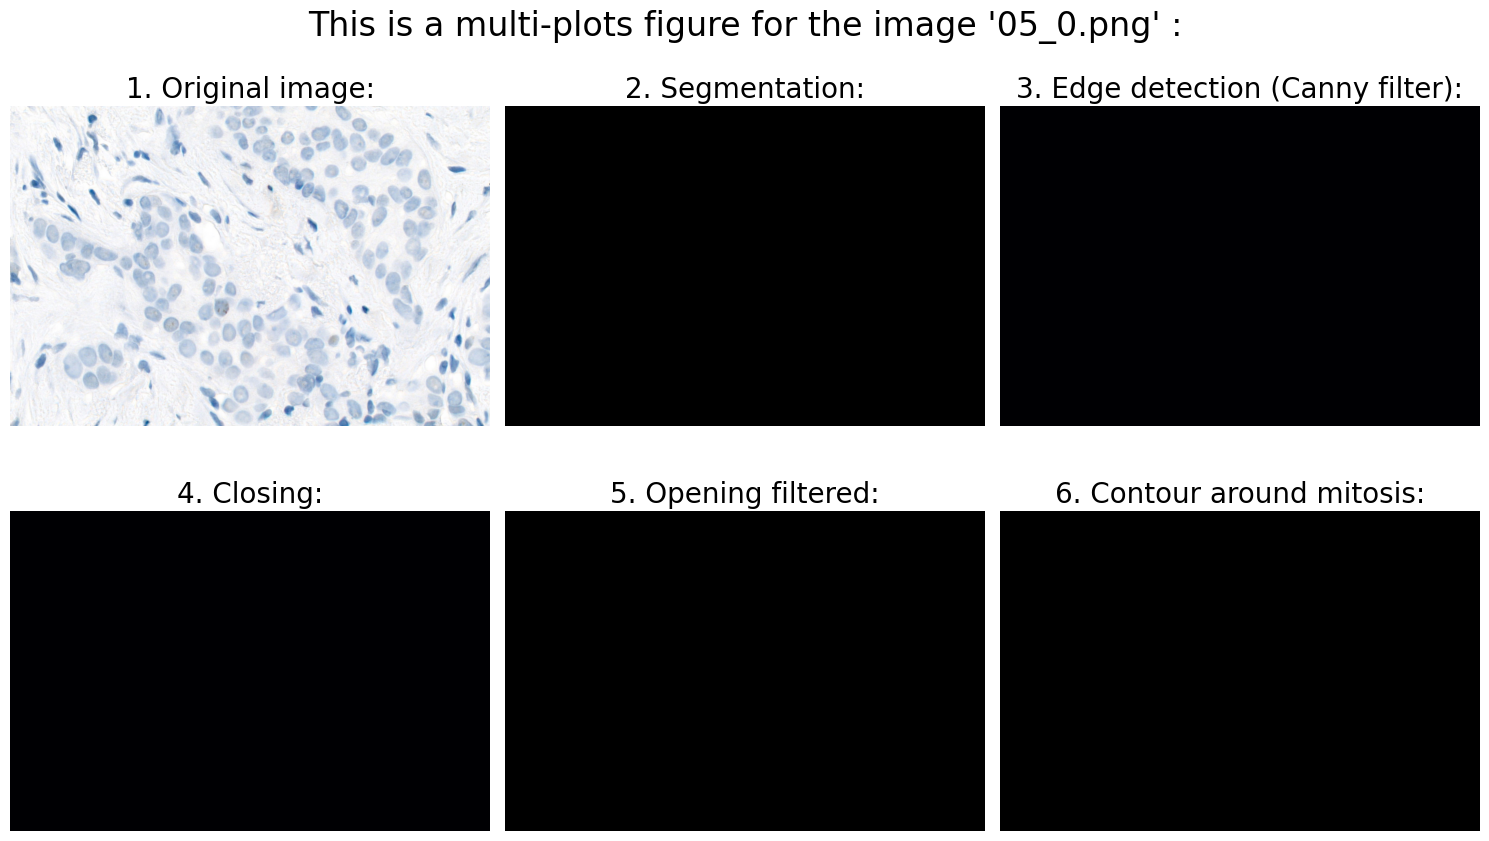

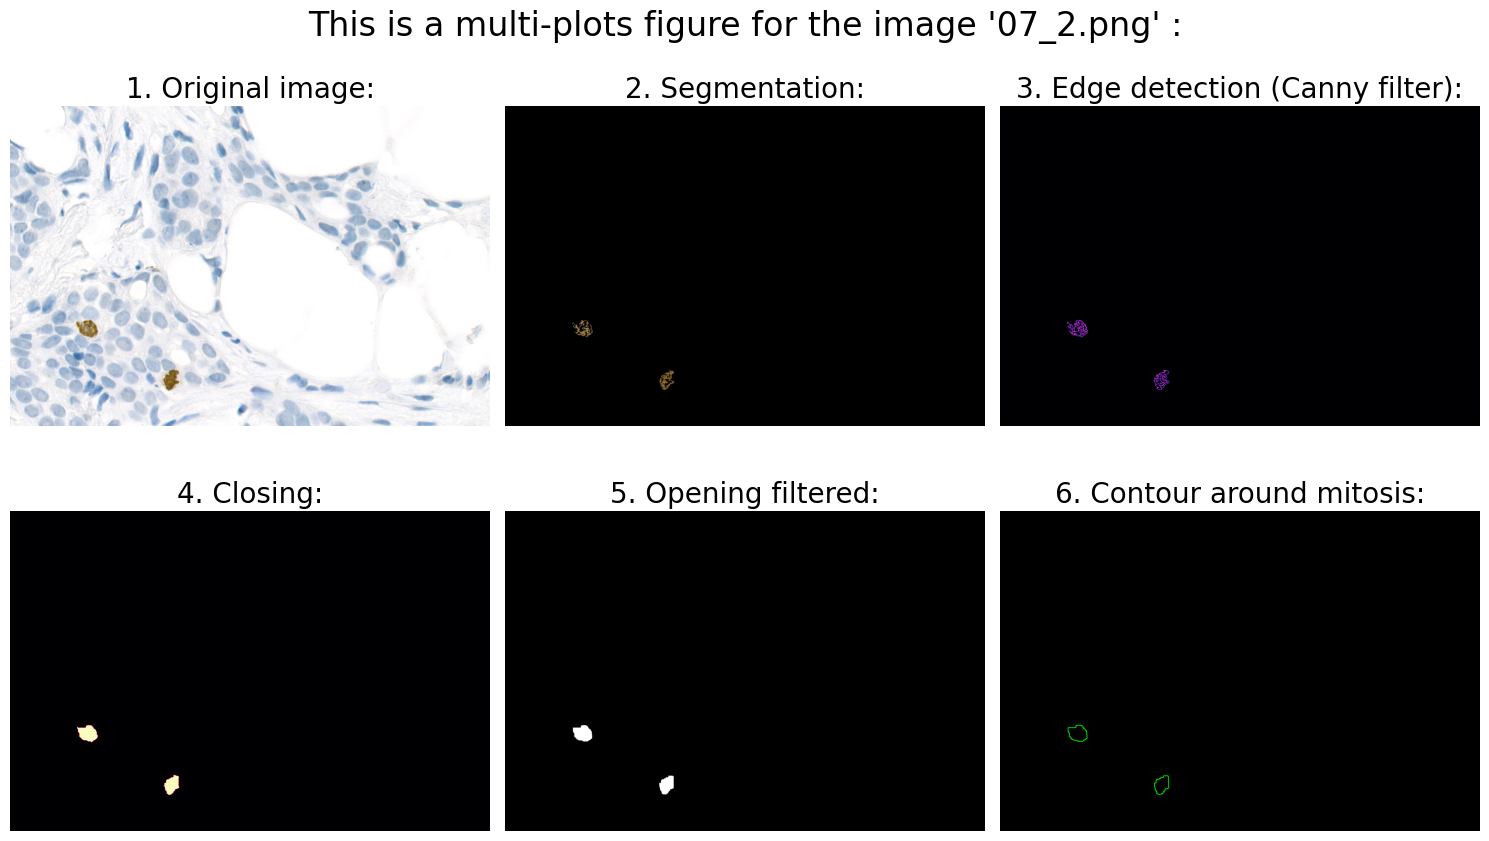

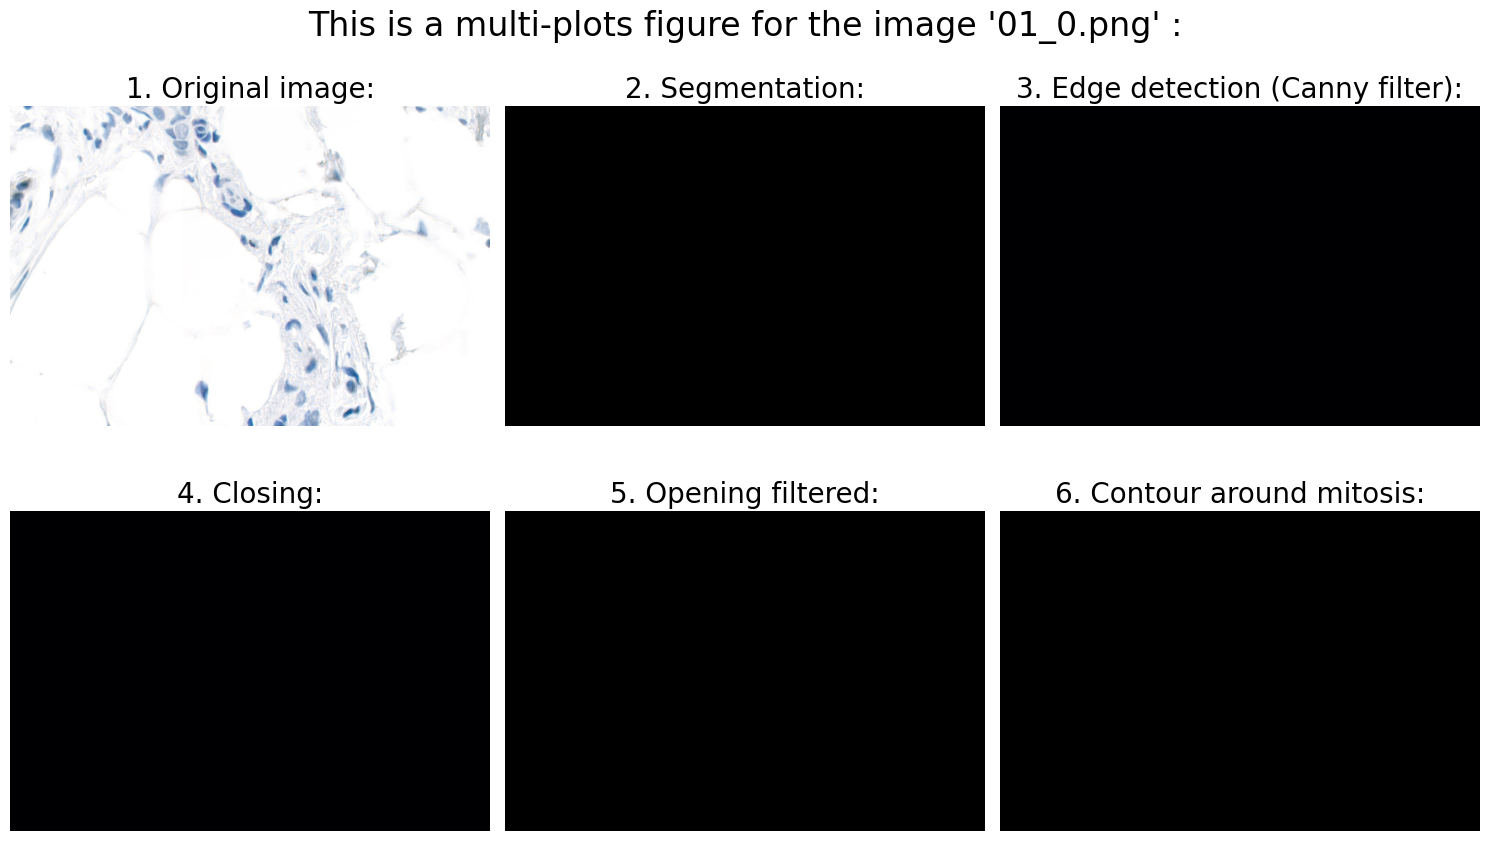

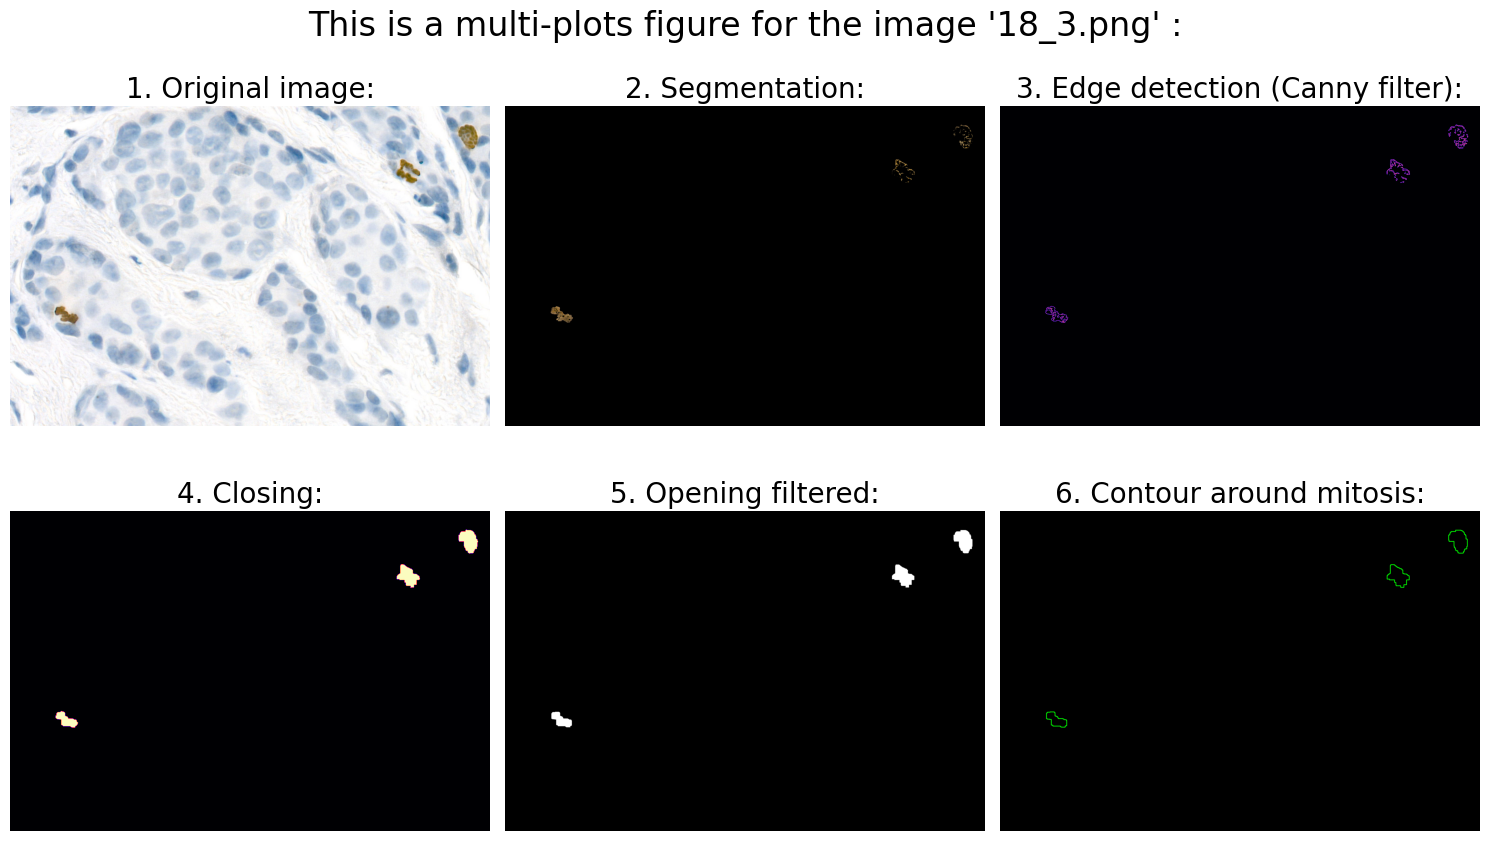

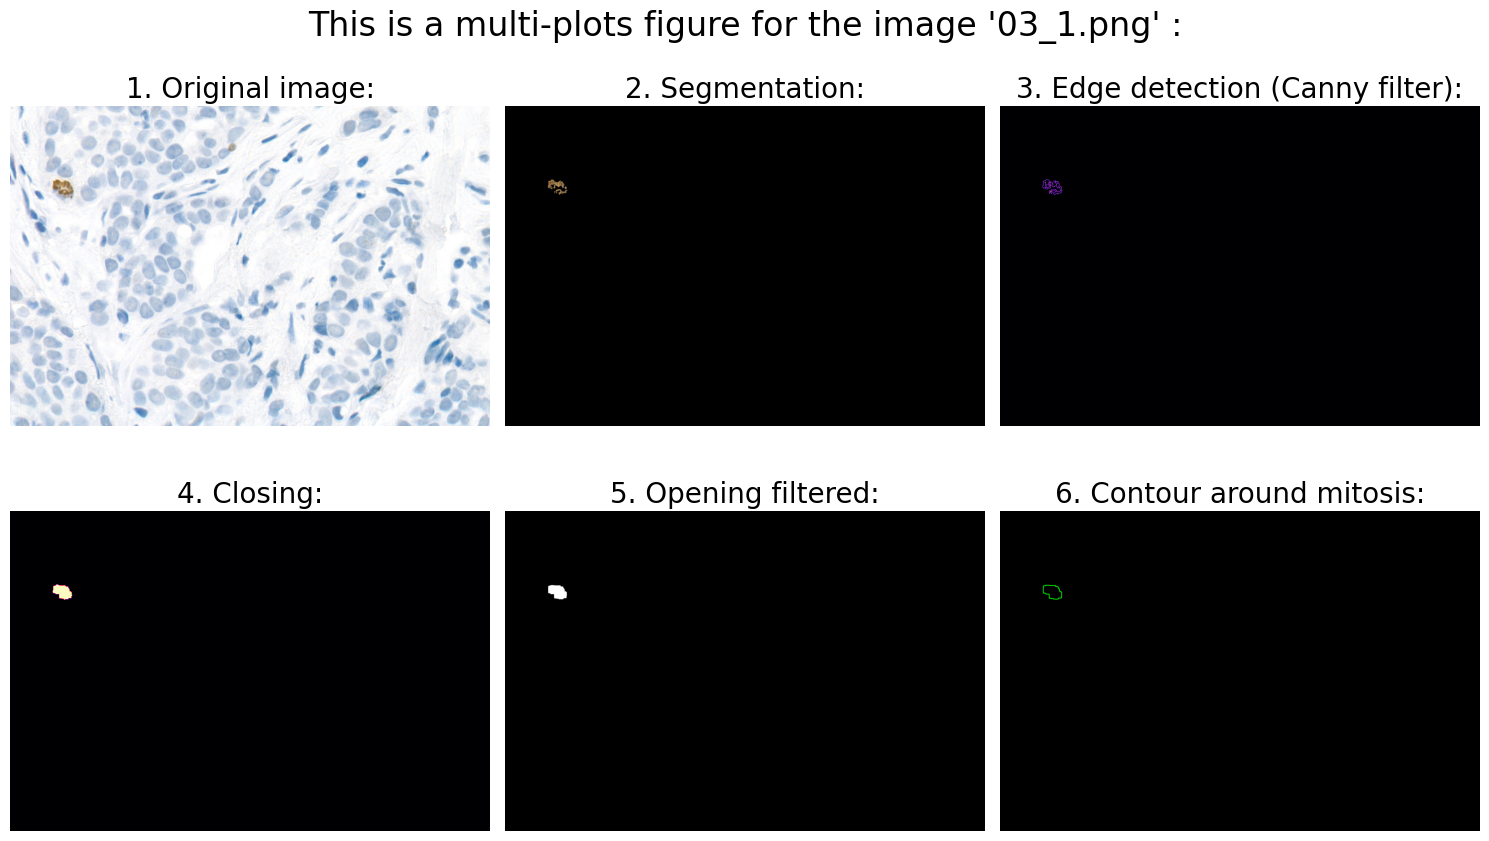

In [4]:
import numpy as np
import imutils
import argparse
import cv2
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

# This program finds all mitoses in all 20 photos with 100% accuracy. Please press "p" to check:
answer = input("'Enter' - display only the results, \n'p' - display the results along with an automatic check:\n")

path = "mitosis_data_set/"

files = [f for f in listdir(path) if isfile(join(path, f))]
correct_solutions = 0   # <- for auto-check

for file in files:
    # 1.0 Open image:
    file_name = file
    img = cv2.imread(path + file_name)

    # 2.0 Preprocessing:
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # for demonstration in plot
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)  # for further segmentation

    # 3.0 Segmentation:

    # 3.1 Define the color range to detect for brown:
    lower_brown = np.array([10, 100, 20])
    upper_brown = np.array([20, 255, 200])
    # Why these values? It is known that mitoses in these images are recognizable as brownish structures.
    # Therefore, the HSV range for BROWN color in openCV is needed here:
    # https://stackoverflow.com/questions/46112326/what-is-the-range-of-hsv-values-for-brown-color-in-opencv
    # By applying a mask for brown, we select all brown objects in the image:
    mask_brown = cv2.inRange(hsv_img, lower_brown, upper_brown)

    # 3.2 Apply the mask:
    result = cv2.bitwise_and(rgb_img, rgb_img, mask=mask_brown)

    # 4.0 Object detection:

    # 4.1 The goal of this step is to detect geometric objects in a grayscale image after segmentation:
    gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

    # 4.2 Algorithm for detecting geometric structures: edge detection -> Canny filter
    # (https://www.uni-ulm.de/fileadmin/website_uni_ulm/mawi.inst.070/funken/bachelorarbeiten/bachelorarbeitBekeJungeEnd.pdf)
    edges = cv2.Canny(gray, 100, 250)  # The second and third arguments are our minVal and maxVal.
    # Why these values?
    # a) All edges with an intensity greater than "maxVal" are the sure edges.
    # b) All edges with an intensity less than "minVal" are definitely not edges.
    # c) The edges between the "maxVal" and "minVal" thresholds are classified as edges only if they are connected to a sure edge, otherwise, they are discarded.
    # This ratio is a recommendation from Canny! -> https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
    # So, Canny recommended an upper:lower ratio between 2:1 and 3:1. Hence, the most average value 2.5:1 was chosen

    # 4.3 Calculation of suitable features:
    # First, we need to perform some morphological transformations (closing & opening).

    # We want to close gaps within the edges to make the objects more cohesive
    # and facilitate the finding of contours:
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=7)
    # Then we want to remove some noise:
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=3)

    # Why these values? A 5x5 kernel, 7 closing iterations, and 3 opening iterations allow us
    # to detect contours of at least 168.5 pixels in size. This is the size
    # of the contour found in image '19_2.png' that is not mitosis.
    # This means that this configuration is empirically (95% accuracy) quite accurate and sensitive.
    # Why?
    # Given the image resolution, the nucleus of mammalian cells takes up approximately 41 to 123 pixels.
    # Thus, the program is able to recognize contours with an area close to the nucleus of mammalian cells
    # at the given image resolution.
    # In the next step, we need to eliminate all contours that have too little surface area (<480 pixels, empirically).

    # We can now use .findContours and .drawContours
    # to retrieve the external contours found by the Canny detection and modified by us ...:
    contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask:
    mask = np.zeros(opening.shape[:2], dtype=opening.dtype)

    # Draw all contours larger than 480 on the mask (see above):
    for c in contours:
        if cv2.contourArea(c) > 480:  # (see above)
            x, y, w, h = cv2.boundingRect(c)
            cv2.drawContours(mask, [c], 0, (255), -1)

    # Apply the mask to the original image:
    opening_filtered = cv2.bitwise_and(opening, opening, mask=mask)

    # Use .findContours again:
    contours_filtered, hierarchy_filtered = cv2.findContours(opening_filtered, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # ... and draw contour around mitosis on a black background for clarification:
    ret, black = cv2.threshold(rgb_img, 255, 255, cv2.THRESH_BINARY)
    img_contours = cv2.drawContours(black, contours_filtered, -1, (0, 255, 0), 2)

    # 5.0 Analysis:

    number_of_objects_in_image = len(contours_filtered)

    if answer == "p":
        # ---- info + auto-check: ----
        file_name_last_char_int = int(file_name[-5])
        if number_of_objects_in_image == file_name_last_char_int:
            print("Found mitoses in the image " + "'" + file_name + "'" + ":", str(number_of_objects_in_image), "✅")
            correct_solutions += 1
        else:
            print("Found mitoses in the image " + "'" + file_name + "'" + ":", str(number_of_objects_in_image), "❌")
    else:
        # ------ only info: ------
        print("Found mitoses in the image " + "'" + file_name + "'" + ":", str(number_of_objects_in_image))

    # 6.0 Visualization:

    # 6.1 Define fig:
    fig_title = "This is a multi-plots figure for the image " + "'" + file_name + "'" + " :"
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
    fig.suptitle(fig_title, fontsize=24, y=0.98)

    # 6.2 Original image:
    ax1.imshow(rgb_img)
    ax1.axis('off')
    ax1.set_title('1. Original image:', fontsize=20)

    # 6.3 Segmentation:
    ax2.imshow(result)
    ax2.axis('off')
    ax2.set_title('2. Segmentation:', fontsize=20)

    # 6.4 Edge detection (Canny filter):
    ax3.imshow(edges, cmap='magma')
    ax3.axis('off')
    ax3.set_title('3. Edge detection (Canny filter):', fontsize=20)

    # 6.5 Closing:
    ax4.imshow(closing, cmap='magma')
    ax4.axis('off')
    ax4.set_title('4. Closing:', fontsize=20)

    # 6.6 Opening filtered:
    ax5.imshow(opening_filtered, cmap="gray")
    ax5.axis('off')
    ax5.set_title('5. Opening filtered:', fontsize=20)

    # 6.7 Contour around mitosis:
    ax6.imshow(img_contours)
    ax6.axis('off')
    ax6.set_title('6. Contour around mitosis:', fontsize=20)

    # 6.8 Show plt:
    fig.subplots_adjust(wspace=0.4, hspace=0.9, top=1.0,
                        bottom=0.02, left=0.02, right=0.98)
    plt.tight_layout()

if answer == "p":
    # The accuracy of the result is immediately visible for a large number of images:
    total_percentage_of_correct_answers = (correct_solutions / len(files)) * 100
    print("")
    print("Percentage of correct solutions: ", str(total_percentage_of_correct_answers), "%")
